# Sharpe Ratio based on Daily vs. Monthly Returns

This note demonstrates the difference in Sharpe ratios based on daily and monthly returns

1. Assets: State Street SPDR U.S. sector ETF's
2. Period: 2012/02/01 to 2022/01/31, 10 years
3. Data source: Alpha Vantage (close price, AV starts to charge adjusted close price data since 2022)

In [1]:
import os
import collections

import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib import pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

%matplotlib inline

In [2]:
%run sharpe  # Python script for this notebook 

## DATA: SP500 ETF and U.S. Sector ETFs

In [3]:
# ETF information 
info = get_sector_etf_info().reset_index(drop=True)
row_bench = pd.DataFrame([{'Ticker': 'SPY', 'Name': 'S&P 500'}])
info = pd.concat([row_bench, info]).reset_index(drop=True)

tix2name = {k: '{} ({})'.format(k, v) for k, v in info.set_index('Ticker')['Name'].items()}
tickers = info['Ticker'].tolist()

info

,Ticker,Name
0,SPY,S&P 500
1,XLE,Energy
2,XLB,Materials
3,XLI,Industrial
4,XLY,Consumer Discretionary
5,XLP,Consumer Staples
6,XLV,Health Care
7,XLF,Financials
8,XLK,Information Technology
9,XLU,Utilities


,SPY,XLE,XLB,XLI,XLY,XLP,XLV,XLF,XLK,XLU
Date,,,,,,,,,,
2012-02-01,132.47,70.97,37.55,36.61,41.46,32.26,36.15,14.28,27.30,34.80
2012-02-02,132.68,71.51,37.37,36.63,41.41,32.38,36.01,14.35,27.37,34.74
2022-01-28,441.95,65.63,83.22,99.70,178.10,75.68,130.48,38.72,158.00,67.96
2022-01-31,449.91,65.92,84.45,100.74,184.95,75.97,131.23,39.06,161.97,69.25


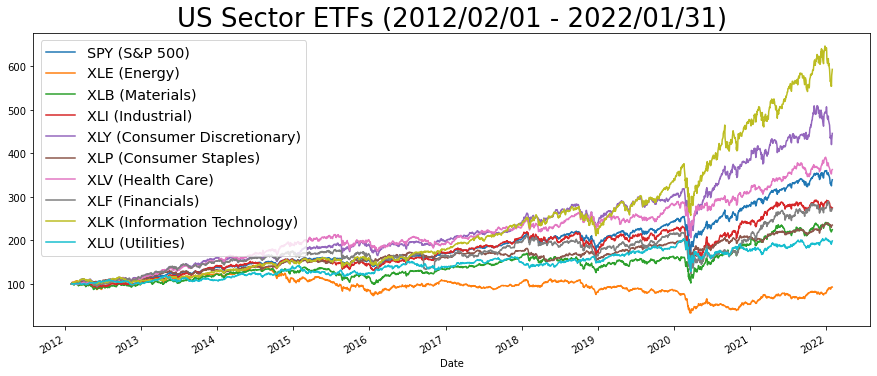

In [4]:
# Load data 
# start = pd.to_datetime('1999/11/01')  # inception
# start = pd.to_datetime('2002/02/01') # 20 years
start = pd.to_datetime('2012/02/01') # 10 years
end = pd.to_datetime('2022/01/31')

df_close = get_ts(tickers, item='close', start=start, end=end)  # As 2022, adjusted_close no longer free

# Plot 
plot_normalized_ts(df_close, title='US Sector ETFs', start=start, end=end, rename=tix2name, figsize=(15,6))

# Display close ETF price
pd.concat([df_close.head(2), df_close.tail(2)])

## Sharpe Ratio and Annualized Volatility Estimates Comparison  
1. Based on daily data
2. Based on monthly data

In [5]:
df_stats = compute_performance_stats_dm(df_close)
df_stats.rename(index=tix2name, inplace=True)

cols_pct = [(x, y) for x in ['Return', 'Volatility'] for y in ['Daily', 'Monthly']]
cols_dec = [('Sharpe', y) for y in ['Daily', 'Monthly']]
cols = cols_pct + cols_dec

fmt = {x: '{:.1%}' for x in cols_pct}
fmt.update({x: '{:.2f}' for x in cols_dec})
df_stats[cols].style.format(formatter=fmt)

## Adjusted Volatility Estimate by AR(p=1) model
AR(1) Volatility = Residual Volatility / ( 1 - AR1 Coeff^2 )

AR(1) shortens the gap between annualized volatility estimates between daily and monthly data to some extent. 

In [6]:
ar_stats = run_ar_models_dm(df_close)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [7]:
df_vol = pd.concat([df_stats[['Volatility']], ar_stats[['AR_Vol']].rename(index=tix2name)], axis=1)
df_vol

Volatility              AR_Vol          
                                  Daily   Monthly     Daily   Monthly
SPY (S&P 500)                  0.162642  0.132672  0.164343  0.134457
XLE (Energy)                   0.279281  0.274754  0.279627  0.275107
XLB (Materials)                0.197201  0.169266  0.197622  0.170497
XLI (Industrial)               0.189600  0.164273  0.190044  0.166146
XLY (Consumer Discretionary)   0.178714  0.160440  0.179223  0.163065
XLP (Consumer Staples)         0.140500  0.119160  0.141553  0.120297
XLV (Health Care)              0.166644  0.135794  0.167808  0.139638
XLF (Financials)               0.221646  0.191110  0.223133  0.191558
XLK (Information Technology)   0.202937  0.157284  0.206229  0.158202
XLU (Utilities)                0.177873  0.139122  0.178707  0.142409

## Auto-correlation

Running AR(1)-model on both monthly and daily return data, both have negative AR(1)-coefficient. (see column *AR1_Coeff*)

Monthly data has a larger magnitude, except *XLF* Financial and *XLK* Information Technology. 

Negative auto-correlation implies there is some intra-monthy mean reversion in price data. 

In [8]:
cols_pct = [(x, y) for x in ['AR_Vol', 'Sigma_Vol'] for y in ['Daily', 'Monthly']]
cols_dec = [('AR1_Coeff', y) for y in ['Daily', 'Monthly']]

fmt = {x: '{:.1%}' for x in cols_pct}
fmt.update({x: '{:.2f}' for x in cols_dec})
ar_stats.rename(index=tix2name).style.format(formatter=fmt)

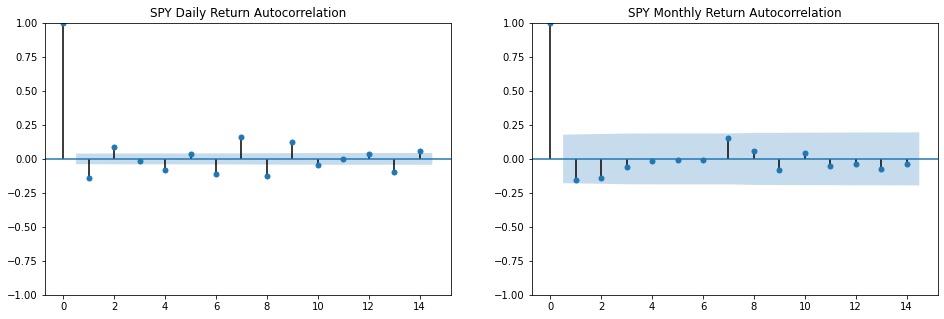

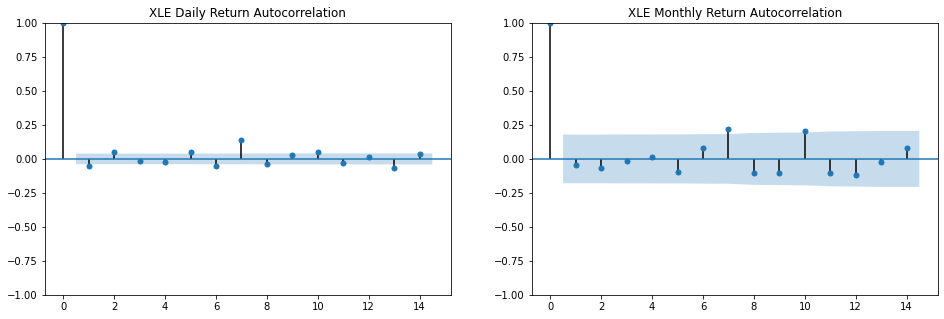

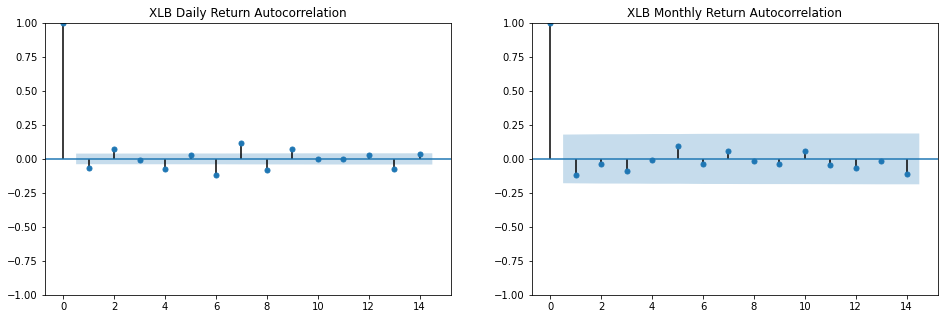

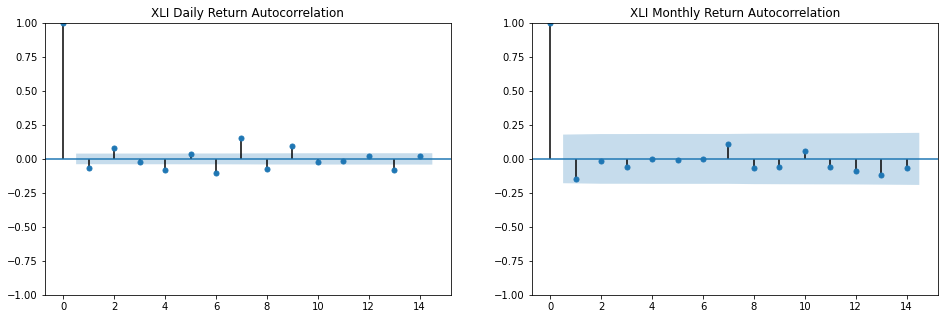

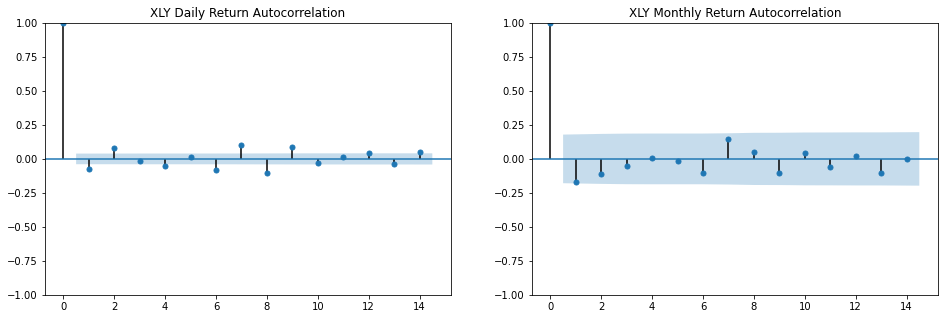

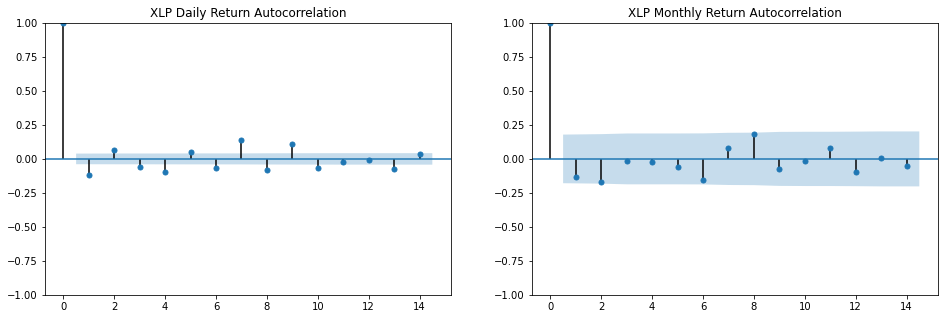

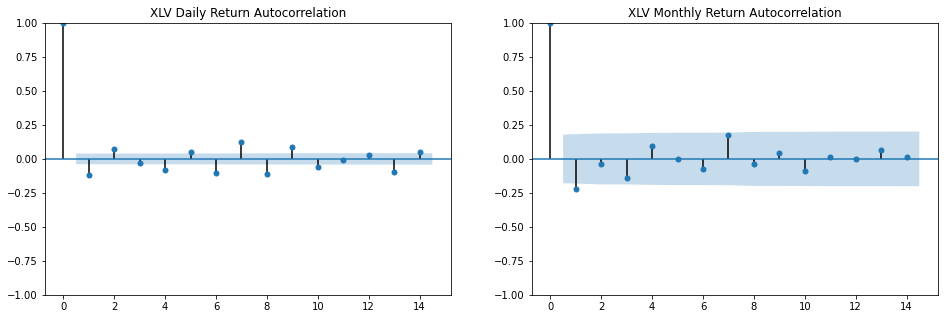

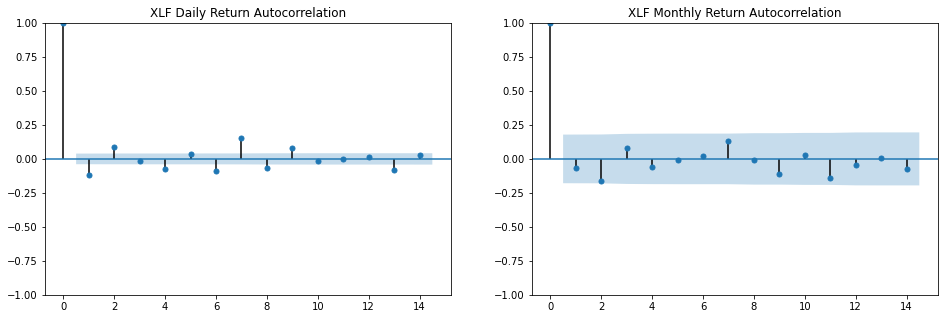

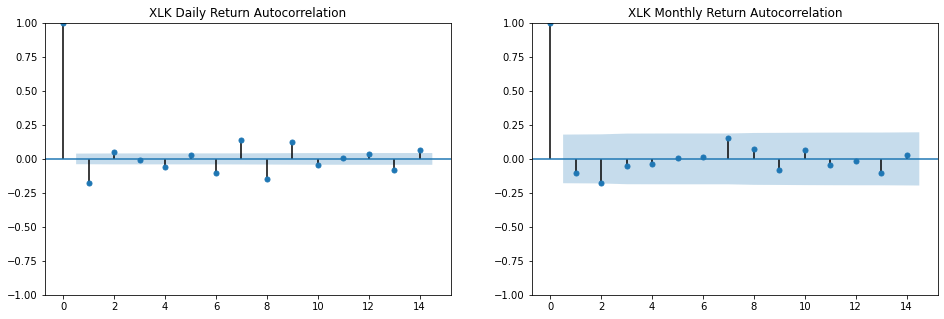

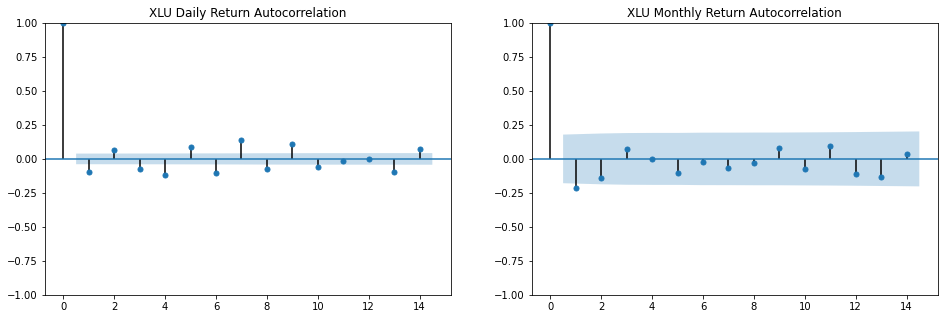

In [9]:
# Auto-Correlation Plots 
figs = plot_acf_dm(df_close)

In [10]:
'Last Update = {}'.format(datetime.datetime.now())

'Last Update = 2022-02-07 01:08:28.502680'